In [133]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_model import CGANModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from time import time
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds_test = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/[0-1].nc', combine='nested', concat_dim='run')
ds_train = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/[1-2].nc', combine='nested', concat_dim='run')

# OLS Model

In [3]:
model = OLSModel()

In [4]:
model.fit(ds_train, ds_test, num_epochs=1)
model.fit(ds_train, ds_test, num_epochs=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.52/0.00] Loss: [1.307, 1.007]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.46/0.00] Loss: [1.303, 1.013]


In [150]:
model.predict(ds_test)

<xarray.Dataset>
Dimensions:                   (run: 2, time: 86, lev: 2, y: 64, x: 64)
Dimensions without coordinates: run, time, lev, y, x
Data variables:
    q_forcing_advection       (run, time, lev, y, x) float32 -6.708e-13 ... -...
    q_forcing_advection_mean  (run, time, lev, y, x) float32 -6.708e-13 ... -...
    q_forcing_advection_var   (run, time, lev, y, x) float32 -0.0 -0.0 ... -0.0

In [152]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='AR1', nsteps=1)
%time m.run()

CPU times: user 379 ms, sys: 711 µs, total: 380 ms
Wall time: 381 ms


# MeanVar model

In [153]:
model = MeanVarModel()

In [154]:
model.fit(ds_train, ds_test, num_epochs=1)
model.fit(ds_train, ds_test, num_epochs=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.47/0.00] Loss: [1.407, 1.007]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [8.729, 8.487]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [1.403, 1.026]
Training starts on device Quadro RTX 8000, number of samples 172
[1/1] [0.45/0.00] Loss: [8.812, 8.575]


In [155]:
model.predict(ds_test)

<xarray.Dataset>
Dimensions:                   (run: 2, time: 86, lev: 2, y: 64, x: 64)
Dimensions without coordinates: run, time, lev, y, x
Data variables:
    q_forcing_advection       (run, time, lev, y, x) float64 5.833e-12 ... -2...
    q_forcing_advection_mean  (run, time, lev, y, x) float32 7.516e-14 ... 2....
    q_forcing_advection_var   (run, time, lev, y, x) float32 3.419e-23 ... 8....

In [156]:
offline = model.test_offline(ds_test)

In [157]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='constant', nsteps=1)
%time m.run()

CPU times: user 728 ms, sys: 3.42 ms, total: 732 ms
Wall time: 734 ms


# CGAN Model

In [167]:
model = CGANModel()
model.fit(ds_train, ds_test, num_epochs=2, nruns=1)

Training starts on device Quadro RTX 8000, number of samples 172
[1/2] [2.23/2.23] D_loss: -0.03 G_loss: -0.09 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
[2/2] [2.19/0.00] D_loss: -0.17 G_loss: -0.52 L2_mean: [1.000,1.000] L2_total: [1.000,1.000] L2_res: [1.000,1.000]
Optimal epoch is 2
checkpoints/G_2.pt  is loaded


In [160]:
offline = model.test_offline(ds_test)

In [161]:
m = stochastic_QGModel({'parameterization': model, 'tmax':10*86400}, sampling_type='AR1', nsteps=1)
%time m.run()

CPU times: user 417 ms, sys: 2.74 ms, total: 420 ms
Wall time: 421 ms


# Do models converge somewhere after adaptation?

In [120]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator1-64/*.nc', combine='nested', concat_dim='run')
ds_test = ds.isel(run=slice(0,25))
ds_train = ds.isel(run=slice(-250,None))

In [123]:
model = OLSModel()
model.fit(ds_train, ds_test, num_epochs=10)
ols = model.test_offline(ds_test)
ols[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.40/435.60] Loss: [0.346, 0.205]
[2/10] [48.36/387.04] Loss: [0.190, 0.176]
[3/10] [48.42/338.75] Loss: [0.172, 0.189]
[4/10] [48.44/290.43] Loss: [0.160, 0.153]
[5/10] [48.45/242.08] Loss: [0.151, 0.146]
[6/10] [48.46/193.69] Loss: [0.144, 0.143]
[7/10] [48.46/145.29] Loss: [0.143, 0.142]
[8/10] [48.45/96.86] Loss: [0.141, 0.142]
[9/10] [48.47/48.44] Loss: [0.141, 0.141]
[10/10] [48.46/0.00] Loss: [0.141, 0.142]


Frozen({'L2_mean': <xarray.Variable ()>
array(0.37001002, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.21740732, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(1., dtype=float32)})

In [125]:
model = MeanVarModel()
model.fit(ds_train, ds_test, num_epochs=10)
meanvar = model.test_offline(ds_test)
meanvar[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.41/435.70] Loss: [0.375, 0.203]
[2/10] [48.48/387.55] Loss: [0.189, 0.173]
[3/10] [48.48/339.19] Loss: [0.169, 0.160]
[4/10] [48.48/290.77] Loss: [0.158, 0.152]
[5/10] [48.47/242.31] Loss: [0.151, 0.152]
[6/10] [48.47/193.85] Loss: [0.143, 0.141]
[7/10] [48.48/145.40] Loss: [0.141, 0.140]
[8/10] [48.47/96.93] Loss: [0.140, 0.140]
[9/10] [48.46/48.47] Loss: [0.140, 0.140]
[10/10] [48.47/0.00] Loss: [0.140, 0.140]
Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.48/436.32] Loss: [0.133, 0.086]
[2/10] [48.48/387.84] Loss: [0.084, 0.085]
[3/10] [48.48/339.37] Loss: [0.083, 0.084]
[4/10] [48.47/290.87] Loss: [0.083, 0.084]
[5/10] [48.47/242.38] Loss: [0.083, 0.084]
[6/10] [48.46/193.90] Loss: [0.082, 0.083]
[7/10] [48.47/145.42] Loss: [0.082, 0.083]
[8/10] [48.47/96.94] Loss: [0.082, 0.083]
[9/10] [48.48/48.47] Loss: [0.082, 0.083]
[10/10] [48.48/0.00] Loss: [0.082, 0.083]


Frozen({'L2_mean': <xarray.Variable ()>
array(0.3671805, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.16183397, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.6578218, dtype=float32)})

In [126]:
model = CGANModel()
model.fit(ds_train, ds_test, num_epochs=10)
cgan = model.test_offline(ds_test)
cgan[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [68.12/613.05] D_loss: -14.33 G_loss: 2.52 L2_mean: [1.041,1.039] L2_total: [0.332,0.324] L2_res: [0.273,0.274]
[2/10] [68.18/545.20] D_loss: -5.46 G_loss: 7.72 L2_mean: [1.021,1.021] L2_total: [0.396,0.408] L2_res: [0.382,0.394]
[3/10] [68.15/477.04] D_loss: -5.32 G_loss: 6.52 L2_mean: [1.016,1.017] L2_total: [0.185,0.182] L2_res: [0.221,0.219]
[4/10] [68.14/408.87] D_loss: -4.92 G_loss: 9.40 L2_mean: [1.000,1.000] L2_total: [0.310,0.307] L2_res: [0.304,0.296]
[5/10] [68.16/340.74] D_loss: -4.95 G_loss: 10.35 L2_mean: [0.993,0.991] L2_total: [0.245,0.226] L2_res: [0.219,0.210]
[6/10] [68.16/272.60] D_loss: -3.65 G_loss: 7.15 L2_mean: [0.976,0.975] L2_total: [0.193,0.184] L2_res: [0.190,0.183]
[7/10] [68.19/204.46] D_loss: -3.52 G_loss: 7.67 L2_mean: [0.968,0.967] L2_total: [0.154,0.146] L2_res: [0.231,0.218]
[8/10] [68.10/136.30] D_loss: -4.17 G_loss: 7.10 L2_mean: [0.965,0.965] L2_total: [0.124,0.128] L2_res: [

Frozen({'L2_mean': <xarray.Variable ()>
array(0.9647604, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.12365752, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.15846579, dtype=float32)})

In [143]:
model = CGANRegression()
model.fit(ds_train, ds_test, num_epochs=10)
cgan_regression = model.test_offline(ds_test)
cgan_regression[['L2_mean', 'L2_total', 'L2_residual']].variables

Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [48.40/435.59] Loss: [0.335, 0.196]
[2/10] [48.47/387.48] Loss: [0.183, 0.172]
[3/10] [48.47/339.13] Loss: [0.163, 0.154]
[4/10] [48.48/290.74] Loss: [0.153, 0.147]
[5/10] [48.46/242.29] Loss: [0.144, 0.142]
[6/10] [48.47/193.84] Loss: [0.136, 0.134]
[7/10] [48.47/145.38] Loss: [0.134, 0.133]
[8/10] [48.47/96.92] Loss: [0.133, 0.133]
[9/10] [48.45/48.46] Loss: [0.133, 0.133]
[10/10] [48.45/0.00] Loss: [0.133, 0.133]
Training starts on device Quadro RTX 8000, number of samples 21500
[1/10] [68.77/618.89] D_loss: -1.31 G_loss: 1.39 L2_mean: [0.367,0.368] L2_total: [0.137,0.133] L2_res: [0.551,0.543]
[2/10] [68.76/550.10] D_loss: -2.05 G_loss: 2.49 L2_mean: [0.372,0.373] L2_total: [0.099,0.101] L2_res: [0.406,0.414]
[3/10] [68.82/481.48] D_loss: -1.66 G_loss: 1.39 L2_mean: [0.392,0.393] L2_total: [0.080,0.081] L2_res: [0.342,0.342]
[4/10] [68.79/412.70] D_loss: -1.48 G_loss: -0.13 L2_mean: [0.383,0.384] L2_total: [0

Frozen({'L2_mean': <xarray.Variable ()>
array(0.41360438, dtype=float32), 'L2_total': <xarray.Variable ()>
array(0.06252422, dtype=float32), 'L2_residual': <xarray.Variable ()>
array(0.20198695, dtype=float32)})

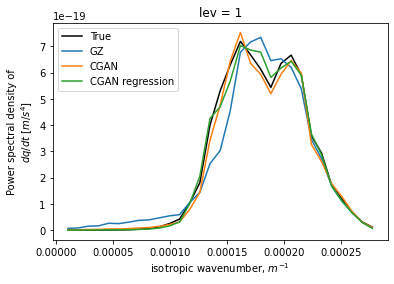

In [174]:
ols.PSD.isel(lev=0).plot(label='True', color='k')
#ols.PSD_gen.isel(lev=1).plot(label='OLS')
meanvar.PSD_gen.isel(lev=0).plot(label='GZ')
cgan.PSD_gen.isel(lev=0).plot(label='CGAN')
cgan_regression_100.PSD_gen.isel(lev=0).plot(label='CGAN regression')
plt.legend()

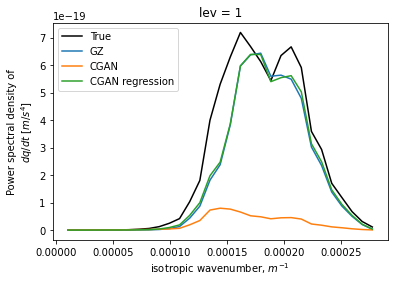

In [172]:
ols.PSD.isel(lev=0).plot(label='True', color='k')
#ols.PSD_gen.isel(lev=1).plot(label='OLS')
meanvar.PSD_mean.isel(lev=0).plot(label='GZ')
cgan.PSD_mean.isel(lev=0).plot(label='CGAN')
cgan_regression_100.PSD_mean.isel(lev=0).plot(label='CGAN regression')
plt.legend()

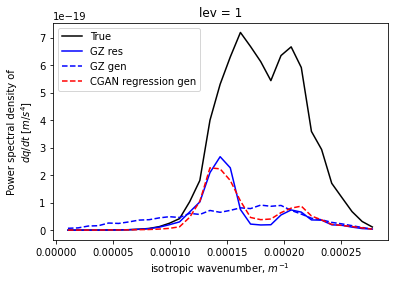

In [178]:
ols.PSD.isel(lev=0).plot(label='True', color='k')
#ols.PSD_gen.isel(lev=1).plot(label='OLS')
meanvar.PSD_res.isel(lev=0).plot(label='GZ res', color='b')
meanvar.PSD_gen_res.isel(lev=0).plot(label='GZ gen', color='b', ls='--')
cgan_regression_100.PSD_gen_res.isel(lev=0).plot(label='CGAN regression gen', color='r', ls='--')
plt.legend()

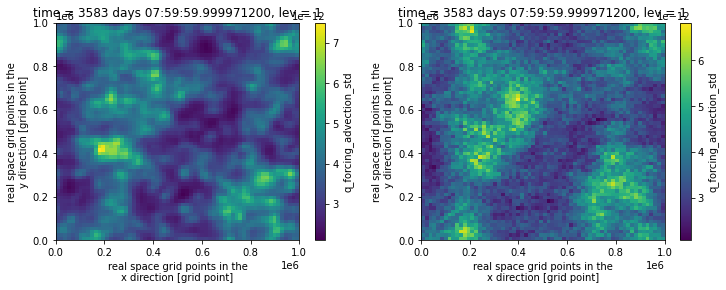

In [189]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
meanvar.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()
plt.subplot(1,2,2)
cgan_regression_100.q_forcing_advection_std.isel(run=0, time=-1, lev=0).plot()

# Typical runtime
- 16 mins for 20 years run for OLS Model on 1 core. 
- 32 min for GZ model. 
- 16 mins for cGAN without separation

In [98]:
m = stochastic_QGModel({'parameterization': model, 'dt': 14400, 'tmax': 360*86400})
t = time()
m.run()
print('Time for 20 years run in mins=', (time()-t)*20/60)

Time for 20 years run in mins= 11.250957330067953
